In [1]:
from utils.fast_cmod5n import *
from glob import glob
from pathlib import Path
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches
from scipy import stats
import seaborn as sns
import matplotlib.lines as mlines


In [2]:
processed_data_path = Path("processed_data")
df_wv1 = pd.read_parquet(processed_data_path / 'wv1_complete.parquet')
df_wv2 = pd.read_parquet(processed_data_path / 'wv2_complete.parquet')

In [3]:
# columns that have matrices as entries

for col in df_wv1.columns:
    if isinstance(df_wv1[col].iloc[0], np.ndarray):
        print(col)

true_sigma0_row_var
true_sigma0_column_var
sigma0_cmod_row_var
sigma0_cmod_column_var


In [4]:
# all columns

df_wv1.columns

Index(['value', 'wm_type', 'lonlat_center', 'tif_path', 'process_status',
       'class_1', 'prob_1', 'class_2', 'prob_2', 'class_3', 'prob_3',
       'all_prob', 'processing_time', 'filename', 'date_time', 'latitude',
       'longitude', 'L', 'wspd', 'wdir', 'sst', 'airt', 'p', 'rh', 'blh',
       'msdwswrf', 'msdwlwrf', 'renamed_filename', 'exists_ok',
       'path_to_sar_file', 'spectral_stats', 'mean_sigma0', 'var_sigma0',
       'skewness_sigma0', 'kurtosis_sigma0', 'mean_psd2d', 'var_psd2d',
       'skewness_psd2d', 'kurtosis_psd2d', 'mean_psd_band0', 'var_psd_band0',
       'skewness_psd_band0', 'kurtosis_psd_band0', 'mean_psd_band1',
       'var_psd_band1', 'skewness_psd_band1', 'kurtosis_psd_band1',
       'mean_psd_band2', 'var_psd_band2', 'skewness_psd_band2',
       'kurtosis_psd_band2', 'wdir_deg_from_north', 'perturbed_wdir',
       'phi_nominal_median', 'phi_perturbed_median', 'ground_heading_median',
       'azimuth_look_median', 'true_sigma0_median', 'true_sigma0_row_v

In [12]:
# cleaning data of weird "true_sigma0_median" values

df_wv1 = df_wv1[df_wv1['true_sigma0_median'] > -1000]
df_wv2 = df_wv2[df_wv2['true_sigma0_median'] > -1000]

# Calculate normalized error ratio for both datasets
df_wv1['sigma0_norm_error'] = (df_wv1['sigma0_cmod_median'] - df_wv1['true_sigma0_median']) / df_wv1['true_sigma0_median']
df_wv2['sigma0_norm_error'] = (df_wv2['sigma0_cmod_median'] - df_wv2['true_sigma0_median']) / df_wv2['true_sigma0_median']

df_wv2.true_sigma0_median.describe()

count    36962.000000
mean         0.114680
std          0.085500
min          0.005835
25%          0.080956
50%          0.114323
75%          0.142889
max          5.752049
Name: true_sigma0_median, dtype: float64

In [13]:
bin_edges = np.arange(-180, 181, 30)  
bin_labels = [f"{left} to {right}" for left, right in zip(bin_edges[:-1], bin_edges[1:])]

df_wv1['phi_bin'] = pd.cut(df_wv1['phi_nominal_median'], bins=bin_edges, 
                           labels=bin_labels, include_lowest=True, right=False)
df_wv2['phi_bin'] = pd.cut(df_wv2['phi_nominal_median'], bins=bin_edges,
                           labels=bin_labels, include_lowest=True, right=False)

binned_dfs_wv1 = {}
binned_dfs_wv2 = {}
for bin_label in bin_labels:
    binned_dfs_wv1[bin_label] = df_wv1[df_wv1['phi_bin'] == bin_label].copy()
    binned_dfs_wv2[bin_label] = df_wv2[df_wv2['phi_bin'] == bin_label].copy()



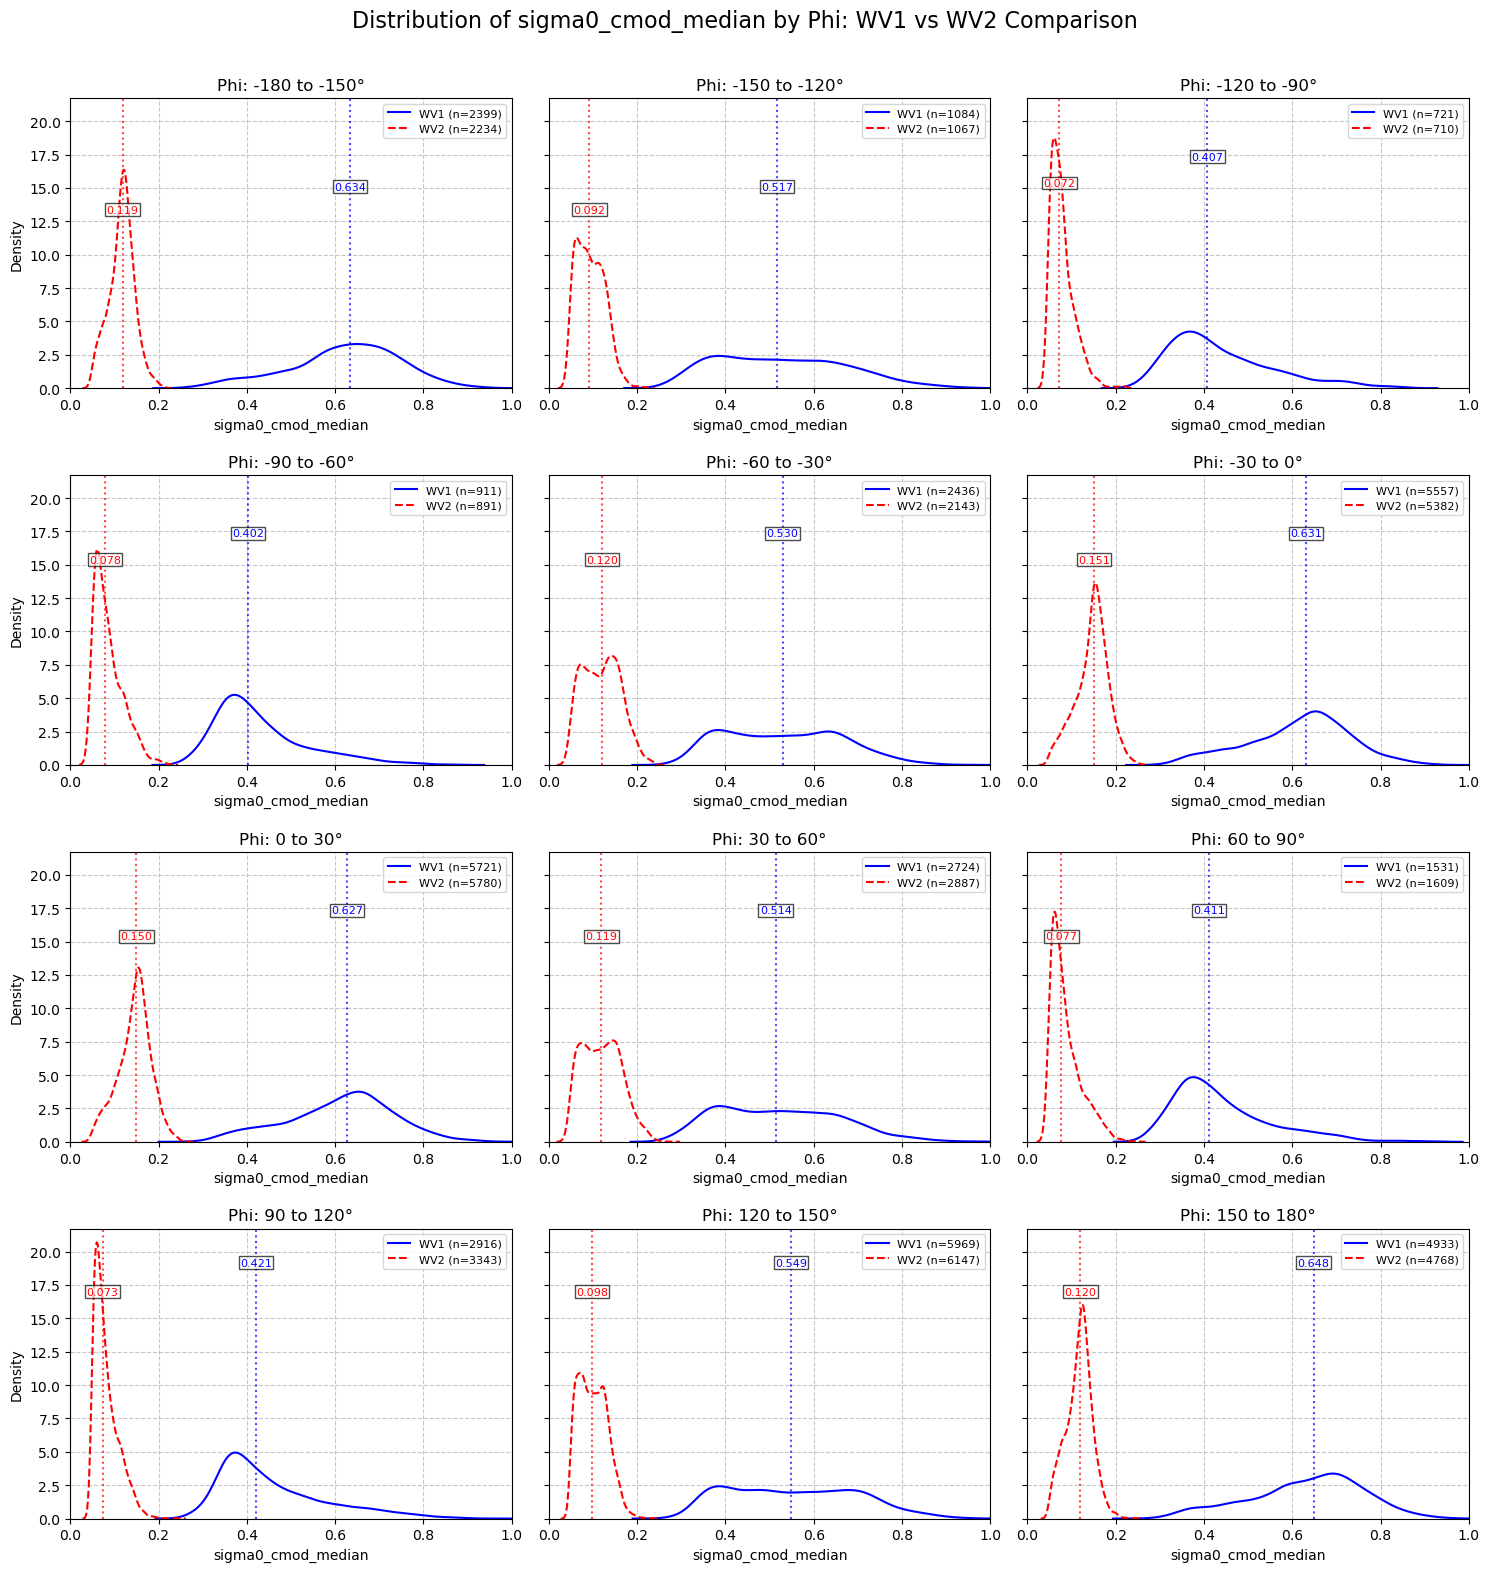

In [17]:
# Create a grid of subplots (4x3 should fit all 12 bins)
fig, axes = plt.subplots(4, 3, figsize=(15, 16), sharey=True)
axes = axes.flatten()  # Flatten to make indexing easier

# Set common x-axis limits
x_min = 0
x_max = 1

# Colors for each mode
wv1_color = 'blue'
wv2_color = 'red'

# Loop through each bin and create a subplot
for i, bin_label in enumerate(bin_labels):
    ax = axes[i]
    
    # Plot WV1 data for this bin
    if not binned_dfs_wv1[bin_label].empty and len(binned_dfs_wv1[bin_label]) > 5:
        sns.kdeplot(
            binned_dfs_wv1[bin_label]['sigma0_cmod_median'], 
            ax=ax,
            label=f'WV1 (n={len(binned_dfs_wv1[bin_label])})',
            color=wv1_color,
            linestyle='-'
        )
    
    # Plot WV2 data for this bin
    if not binned_dfs_wv2[bin_label].empty and len(binned_dfs_wv2[bin_label]) > 5:
        sns.kdeplot(
            binned_dfs_wv2[bin_label]['sigma0_cmod_median'], 
            ax=ax,
            label=f'WV2 (n={len(binned_dfs_wv2[bin_label])})',
            color=wv2_color,
            linestyle='--'
        )
    
    # Set subplot title and axes labels
    ax.set_title(f'Phi: {bin_label}°', fontsize=12)
    ax.set_xlabel('sigma0_cmod_median', fontsize=10)
    ax.set_ylabel('Density', fontsize=10)
    ax.set_xlim(x_min, x_max)
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.legend(fontsize=8)

    # Add median values as vertical lines with text annotations
    if not binned_dfs_wv1[bin_label].empty and len(binned_dfs_wv1[bin_label]) > 5:
        median_wv1 = binned_dfs_wv1[bin_label]['sigma0_cmod_median'].median()
        ax.axvline(median_wv1, color=wv1_color, linestyle=':', alpha=0.7)
        ax.text(median_wv1, ax.get_ylim()[1]*0.9, f'{median_wv1:.3f}', 
                color=wv1_color, ha='center', va='top', fontsize=8, 
                bbox=dict(facecolor='white', alpha=0.7, pad=1))
    
    if not binned_dfs_wv2[bin_label].empty and len(binned_dfs_wv2[bin_label]) > 5:
        median_wv2 = binned_dfs_wv2[bin_label]['sigma0_cmod_median'].median()
        ax.axvline(median_wv2, color=wv2_color, linestyle=':', alpha=0.7)
        ax.text(median_wv2, ax.get_ylim()[1]*0.8, f'{median_wv2:.3f}', 
                color=wv2_color, ha='center', va='top', fontsize=8,
                bbox=dict(facecolor='white', alpha=0.7, pad=1))

# Remove any unused subplots
for j in range(len(bin_labels), len(axes)):
    fig.delaxes(axes[j])

# Add overall title
fig.suptitle('Distribution of sigma0_cmod_median by Phi: WV1 vs WV2 Comparison', fontsize=16)

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.subplots_adjust(hspace=0.3)
plt.savefig("images/sigma0_cmod_median.jpg")
plt.show()

In [ ]:


# Create a grid of subplots
fig, axes = plt.subplots(4, 3, figsize=(15, 16), sharey=True)
axes = axes.flatten()

# Colors for each mode
wv1_color = 'blue'
wv2_color = 'red'

# Loop through each bin and create a subplot
for i, bin_label in enumerate(bin_labels):
    ax = axes[i]
    
    # Plot WV1 normalized error for this bin
    if not binned_dfs_wv1[bin_label].empty and len(binned_dfs_wv1[bin_label]) > 5:
        sns.kdeplot(
            binned_dfs_wv1[bin_label]['sigma0_norm_error'], 
            ax=ax,
            label=f'WV1 (n={len(binned_dfs_wv1[bin_label])})',
            color=wv1_color,
            linestyle='-'
        )
    
    # Plot WV2 normalized error for this bin
    if not binned_dfs_wv2[bin_label].empty and len(binned_dfs_wv2[bin_label]) > 5:
        sns.kdeplot(
            binned_dfs_wv2[bin_label]['sigma0_norm_error'], 
            ax=ax,
            label=f'WV2 (n={len(binned_dfs_wv2[bin_label])})',
            color=wv2_color,
            linestyle='--'
        )
    
    # Set subplot title and axes labels
    ax.set_title(f'Phi: {bin_label}°', fontsize=12)
    ax.set_xlabel('Normalized σ₀ Error', fontsize=10)
    ax.set_xlim(-5, 5)
    ax.set_ylabel('Density', fontsize=10)
    
    # Add vertical line at zero (perfect match)
    ax.axvline(0, color='black', linestyle='-', alpha=0.5)
    
    # Add grid and legend
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.legend(fontsize=8)
    
    # Add median values as vertical lines with text
    if not binned_dfs_wv1[bin_label].empty and len(binned_dfs_wv1[bin_label]) > 5:
        median_wv1 = binned_dfs_wv1[bin_label]['sigma0_norm_error'].median()
        ax.axvline(median_wv1, color=wv1_color, linestyle=':', alpha=0.7)
        ax.text(median_wv1, ax.get_ylim()[1]*0.9, f'{median_wv1:.3f}', 
                color=wv1_color, ha='center', va='top', fontsize=8,
                bbox=dict(facecolor='white', alpha=0.7, pad=1))
    
    if not binned_dfs_wv2[bin_label].empty and len(binned_dfs_wv2[bin_label]) > 5:
        median_wv2 = binned_dfs_wv2[bin_label]['sigma0_norm_error'].median()
        ax.axvline(median_wv2, color=wv2_color, linestyle=':', alpha=0.7)
        ax.text(median_wv2, ax.get_ylim()[1]*0.8, f'{median_wv2:.3f}', 
                color=wv2_color, ha='center', va='top', fontsize=8,
                bbox=dict(facecolor='white', alpha=0.7, pad=1))

# Remove any unused subplots
for j in range(len(bin_labels), len(axes)):
    fig.delaxes(axes[j])

# Add overall title
fig.suptitle('Normalized σ₀ Error by Phi: WV1 vs WV2 Comparison', fontsize=16)

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.subplots_adjust(hspace=0.3)
plt.savefig("images/normalized_sigma0_error.png")
plt.show()